# Overview
This notebook is for training Longformer-base-4096 of 5 folds and calculating cv score after postprocessing predictions by using average probability of predicted classes. 

A notebook for inferencing is below.

https://www.kaggle.com/ytakayama/inference-pytorch-longformer-5fold

# Reference
Following notebooks are very informative and great. Thanks.
- https://www.kaggle.com/abhishek/two-longformers-are-better-than-1
- https://www.kaggle.com/cdeotte/pytorch-bigbird-ner-cv-0-615
- https://www.kaggle.com/nbroad/corrected-train-csv-feedback-prize


# How to infer
- calculate probability for 15 classes by 5 fold model(LongFormer)

15 classes: OUTPUT_LABELS in "constants" header which mean 14 combinations of 2 NER tags(B- /I-) and 7 elements + others

- calculate class of the highest probability 
 - inference test data: calculate average probability in 5 predictions
 - validate train data: use probability of each fold
- postprocess based on probability of predicted class and how long predcited class is continuous

# customize for executing this notebook on Google Colab
- prepare data: competion data and following data

https://www.kaggle.com/nbroad/corrected-train-csv-feedback-prize
- set variables about directories of Config class (e.g. data_dir)

## setup envirionment

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True
if not ON_KAGGLE:
    import shutil
    from requests import get

    from google.colab import drive, files
    # mount Google Drive
    drive.mount("/content/drive")
    %cd drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/main/
    !pip install  -qq sentencepiece transformers torch==1.9.1 torchvision==0.10.1 torchAudio==0.9.1 torchtext==0.10.1 japanize-matplotlib
else:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

Mounted at /content/drive
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/main
     |████████████████████████████████| 1.2 MB 14.7 MB/s 
     |████████████████████████████████| 3.5 MB 81.3 MB/s 
     |████████████████████████████████| 831.4 MB 5.6 kB/s 
     |████████████████████████████████| 22.1 MB 1.2 MB/s 
     |████████████████████████████████| 1.9 MB 97.6 MB/s 
     |████████████████████████████████| 7.6 MB 74.3 MB/s 
     |████████████████████████████████| 4.1 MB 66.3 MB/s 
     |████████████████████████████████| 596 kB 76.3 MB/s 
     |████████████████████████████████| 895 kB 71.6 MB/s 
     |████████████████████████████████| 6.8 MB 70.6 MB/s 
     |████████████████████████████████| 67 kB 6.5 MB/s 


Config

In [2]:
class Config:
    name = 'fb_nb007'
    model_savename = 'longformer'
    if ON_KAGGLE:
        model_name = '../input/pt-longformer-base' # https://www.kaggle.com/kishalmandal/pt-longformer-base
        # base_dir = '/content/drive/MyDrive/petfinder'
        data_dir = '../input/feedback-prize-2021/'
        pre_data_dir = './preprocessed/'
        model_dir = '.'
        output_dir = '.'
    else:
        # customize for my own Google Colab Environment
        model_name = 'allenai/longformer-base-4096'
        # model_name = 'allenai/longformer-base-4096' # download from Internet
        base_dir = '/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/'
        data_dir = os.path.join(base_dir, 'input/feedback-prize-2021/')
        pre_data_dir = os.path.join(base_dir, 'data/preprocessed')
        model_dir = os.path.join(base_dir, f'model/{name}')
        output_dir = os.path.join(base_dir, f'output/{name}')
    is_debug = False
    load_texts = True
    n_epoch = 3 # not to exceed runtime limits on Kaggle
    n_fold = 5
    verbose_steps = 500
    random_seed = 71
    max_length = 1024
    train_batch_size = 4
    valid_batch_size = 4
    lr = 5e-5
    num_labels = 15
    label_subtokens = True
    output_hidden_states = True
    hidden_dropout_prob = 0.1
    layer_norm_eps = 1e-7
    add_pooling_layer = False
    verbose_steps = 500
    if is_debug:
        debug_sample = 1000
        verbose_steps = 16
        n_epoch = 1
        n_fold = 2

constants

In [3]:
IGNORE_INDEX = -100
NON_LABEL = -1
OUTPUT_LABELS = ['0', 'B-Lead', 'I-Lead', 'B-Position', 'I-Position', 'B-Claim', 'I-Claim', 'B-Counterclaim', 'I-Counterclaim', 
                 'B-Rebuttal', 'I-Rebuttal', 'B-Evidence', 'I-Evidence', 'B-Concluding Statement', 'I-Concluding Statement']
LABELS_TO_IDS = {v:k for k,v in enumerate(OUTPUT_LABELS)}
IDS_TO_LABELS = {k:v for k,v in enumerate(OUTPUT_LABELS)}

MIN_THRESH = {
    "I-Lead": 9,
    "I-Position": 5,
    "I-Evidence": 14,
    "I-Claim": 3,
    "I-Concluding Statement": 11,
    "I-Counterclaim": 6,
    "I-Rebuttal": 4,
}

PROB_THRESH = {
    "I-Lead": 0.7,
    "I-Position": 0.55,
    "I-Evidence": 0.65,
    "I-Claim": 0.55,
    "I-Concluding Statement": 0.7,
    "I-Counterclaim": 0.5,
    "I-Rebuttal": 0.55,
}

In [4]:
if not ON_KAGGLE:
    if not os.path.exists(Config.model_dir):
        os.makedirs(Config.model_dir, exist_ok=True)
    if not os.path.exists(Config.output_dir):
        os.makedirs(Config.output_dir, exist_ok=True)

### libraries

In [5]:
# if not ON_KAGGLE:
#     !pip install -qq transformers

In [6]:
# general
import pandas as pd
import numpy as np
import time
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
japanize_matplotlib.japanize()
import random
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import gc
from collections import defaultdict
# nlp
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
from transformers import LongformerConfig, LongformerModel, LongformerTokenizerFast
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

## preprocess
use corrected train.csv

https://www.kaggle.com/nbroad/corrected-train-csv-feedback-prize/notebook

In [7]:
if ON_KAGGLE:
    df_alltrain = pd.read_csv('../input/corrected-train-csv-feedback-prize/corrected_train.csv')
else:
    df_alltrain = pd.read_csv(f'{Config.data_dir}/corrected_train.csv')

In [8]:
def agg_essays(train_flg):
    folder = 'train' if train_flg else 'test'
    names, texts =[], []
    for f in tqdm(list(os.listdir(f'{Config.data_dir}/{folder}'))):
        names.append(f.replace('.txt', ''))
        texts.append(open(f'{Config.data_dir}/{folder}/' + f, 'r').read())
        df_texts = pd.DataFrame({'id': names, 'text': texts})

    df_texts['text_split'] = df_texts.text.str.split()
    print('Completed tokenizing texts.')
    return df_texts

In [9]:
def ner(df_texts, df_train):
    all_entities = []
    for _,  row in tqdm(df_texts.iterrows(), total=len(df_texts)):
        total = len(row['text_split'])
        entities = ['0'] * total

        for _, row2 in df_train[df_train['id'] == row['id']].iterrows():
            discourse = row2['discourse_type']
            list_ix = [int(x) for x in row2['predictionstring'].split(' ')]
            entities[list_ix[0]] = f'B-{discourse}'
            for k in list_ix[1:]: entities[k] = f'I-{discourse}'
        all_entities.append(entities)

    df_texts['entities'] = all_entities
    print('Completed mapping discourse to each token.')
    return df_texts

In [10]:
if not Config.load_texts:    
    def preprocess(df_train = None):
        if df_train is None:
            train_flg = False
        else:
            train_flg = True
        
        df_texts = agg_essays(train_flg)

        if train_flg:
            df_texts = ner(df_texts, df_train)
        return df_texts
    
    alltrain_texts = preprocess(df_alltrain)
    test_texts = preprocess()
    # alltrain_texts.to_pickle('../input/fb-data/alltrain_texts_correct.pkl')
    # test_texts.to_pickle('../input/fb-data/test_texts_correct.pkl')
else:
    alltrain_texts = pd.read_pickle('../input/fb-data/alltrain_texts_correct.pkl')
    test_texts = pd.read_pickle('../input/fb-data/test_texts_correct.pkl')

In [11]:
if Config.is_debug:
    alltrain_texts = alltrain_texts.sample(Config.debug_sample).reset_index(drop=True)
print(len(alltrain_texts))

15594


set seed & split train/test

In [12]:
def seed_everything(seed=Config.random_seed):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed%(2**32-1))
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False

seed_everything()
# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: cuda


In [13]:
def split_fold(df_train):
    ids = df_train['id'].unique()
    kf = KFold(n_splits=Config.n_fold, shuffle = True, random_state=Config.random_seed)
    for i_fold, (_, valid_index) in enumerate(kf.split(ids)):
        df_train.loc[valid_index,'fold'] = i_fold
    return df_train

alltrain_texts = split_fold(alltrain_texts)
alltrain_texts.head()

,id,text,text_split,entities,fold
0,F48EF80D2ED3,There are many programs in the world around yo...,"[There, are, many, programs, in, the, world, a...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",0.0
1,F8FB4470A52F,"Dear Senator,\n\n""The Electoral College is a p...","[Dear, Senator,, ""The, Electoral, College, is,...","[0, 0, B-Lead, I-Lead, I-Lead, I-Lead, I-Lead,...",0.0
2,F176A8CF72BB,In my opinion i don't think that is fair. i th...,"[In, my, opinion, i, don't, think, that, is, f...","[B-Position, I-Position, I-Position, I-Positio...",4.0
3,EBDE7FC748A4,Unmasking the Face\n\nThe face on Mars was rea...,"[Unmasking, the, Face, The, face, on, Mars, wa...","[0, 0, 0, B-Position, I-Position, I-Position, ...",3.0
4,F6C40C564E5E,Luke think you should join the seagoing cowboy...,"[Luke, think, you, should, join, the, seagoing...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, B-Claim, I-Clai...",4.0


## dataset

In [14]:
class FeedbackPrizeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, has_labels):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.has_labels = has_labels
    
    def __getitem__(self, index):
        text = self.data['text'][index]
        encoding = self.tokenizer(
            text.split(),
            is_split_into_words = True,
            padding = 'max_length',
            truncation = True,
            max_length = self.max_len
        )
        word_ids = encoding.word_ids()

        # targets
        if self.has_labels:
            word_labels = self.data.entities[index]
            prev_word_idx = None
            labels_ids = []
            for word_idx in word_ids:
                if word_idx is None:
                    labels_ids.append(IGNORE_INDEX)
                elif word_idx != prev_word_idx:
                    labels_ids.append(LABELS_TO_IDS[word_labels[word_idx]])
                else:
                    if Config.label_subtokens:
                        labels_ids.append(LABELS_TO_IDS[word_labels[word_idx]])
                    else:
                        labels_ids.append(IGNORE_INDEX)
                prev_word_idx = word_idx
            encoding['labels'] = labels_ids
        # convert to torch.tensor
        item = {k: torch.as_tensor(v) for k, v in encoding.items()}
        word_ids2 = [w if w is not None else NON_LABEL for w in word_ids]
        item['word_ids'] = torch.as_tensor(word_ids2)
        return item

    def __len__(self):
        return self.len

## model

In [15]:
class FeedbackModel(nn.Module):
    def __init__(self):
        super(FeedbackModel, self).__init__()
        model_config = LongformerConfig.from_pretrained(Config.model_name)
        self.model_config = model_config
        self.backbone = LongformerModel.from_pretrained(Config.model_name, config=model_config)
        self.head = nn.Linear(model_config.hidden_size, Config.num_labels)
    
    def forward(self, input_ids, mask):
        x = self.backbone(input_ids, mask)
        logits = self.head(x[0])
        return logits

## utility function

In [16]:
def active_logits(raw_logits, word_ids):
    word_ids = word_ids.view(-1)
    active_mask = word_ids.unsqueeze(1).expand(word_ids.shape[0], Config.num_labels)
    active_mask = active_mask != NON_LABEL
    active_logits = raw_logits.view(-1, Config.num_labels)
    active_logits = torch.masked_select(active_logits, active_mask) # return 1dTensor
    active_logits = active_logits.view(-1, Config.num_labels) 
    return active_logits

def active_labels(labels):
    active_mask = labels.view(-1) != IGNORE_INDEX
    active_labels = torch.masked_select(labels.view(-1), active_mask)
    return active_labels

def active_preds_prob(active_logits):
    active_preds = torch.argmax(active_logits, axis = 1)
    active_preds_prob, _ = torch.max(active_logits, axis = 1)
    return active_preds, active_preds_prob

## evaluating function

In [17]:
def calc_overlap(row):
    """
    calculate the overlap between prediction and ground truth
    """
    set_pred = set(row.new_predictionstring_pred.split(' '))
    set_gt = set(row.new_predictionstring_gt.split(' '))
    # length of each end intersection
    len_pred = len(set_pred)
    len_gt = len(set_gt)
    intersection = len(set_gt.intersection(set_pred))
    overlap_1 = intersection / len_gt
    overlap_2 = intersection / len_pred
    return [overlap_1, overlap_2]

def score_feedback_comp(pred_df, gt_df):
    """
    A function that scores for the kaggle
        Student Writing Competition
        
    Uses the steps in the evaluation page here:
        https://www.kaggle.com/c/feedback-prize-2021/overview/evaluation
    """
    gt_df = gt_df[['id', 'discourse_type', 'new_predictionstring']].reset_index(drop = True).copy()
    pred_df = pred_df[['id', 'class', 'new_predictionstring']].reset_index(drop = True).copy()
    gt_df['gt_id'] = gt_df.index
    pred_df['pred_id'] = pred_df.index
    joined = pred_df.merge(
        gt_df,
        left_on = ['id', 'class'],
        right_on = ['id', 'discourse_type'],
        how = 'outer',
        suffixes = ['_pred', '_gt']
    )
    joined['new_predictionstring_gt'] =  joined['new_predictionstring_gt'].fillna(' ')
    joined['new_predictionstring_pred'] =  joined['new_predictionstring_pred'].fillna(' ')
    joined['overlaps'] = joined.apply(calc_overlap, axis = 1)
    # overlap over 0.5: true positive
    # If nultiple overlaps exists, the higher is taken.
    joined['overlap1'] = joined['overlaps'].apply(lambda x: eval(str(x))[0])
    joined['overlap2'] = joined['overlaps'].apply(lambda x: eval(str(x))[1])

    joined['potential_TP'] = (joined['overlap1'] >= 0.5) & (joined['overlap2'] >= 0.5)
    joined['max_overlap'] = joined[['overlap1', 'overlap2']].max(axis = 1)
    tp_pred_ids = joined.query('potential_TP').sort_values('max_overlap', ascending = False)\
                  .groupby(['id', 'new_predictionstring_gt']).first()['pred_id'].values
    
    fp_pred_ids = [p for p in joined['pred_id'].unique() if p not in tp_pred_ids]
    matched_gt_ids = joined.query('potential_TP')['gt_id'].unique()
    unmatched_gt_ids = [c for c in joined['gt_id'].unique() if c not in matched_gt_ids]

    TP = len(tp_pred_ids)
    FP = len(fp_pred_ids)
    FN = len(unmatched_gt_ids)
    macro_f1_score = TP / (TP + 1/2 * (FP + FN))
    return macro_f1_score

def oof_score(df_val, oof):
    f1score = []
    classes = ['Lead', 'Position','Claim', 'Counterclaim', 'Rebuttal','Evidence','Concluding Statement']
    for c in classes:
        pred_df = oof.loc[oof['class'] == c].copy()
        gt_df = df_val.loc[df_val['discourse_type'] == c].copy()
        f1 = score_feedback_comp(pred_df, gt_df)
        print(f'{c:<10}: {f1:4f}')
        f1score.append(f1)
    f1avg = np.mean(f1score)
    return f1avg

## inferencing function

In [18]:
def inference(model, dl, criterion, valid_flg):
    final_predictions = []
    final_predictions_prob = []
    stream = tqdm(dl)
    model.eval()
    
    valid_loss = 0
    valid_accuracy = 0
    all_logits = None
    for batch_idx, batch in enumerate(stream, start = 1):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        with torch.no_grad():
            raw_logits = model(input_ids=ids, mask = mask)
        del ids, mask
        
        word_ids = batch['word_ids'].to(device, dtype = torch.long)
        if valid_flg:    
            raw_labels = batch['labels'].to(device, dtype = torch.long)
            logits = active_logits(raw_logits, word_ids)
            labels = active_labels(raw_labels)
            preds, preds_prob = active_preds_prob(logits)
            valid_accuracy += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            loss = criterion(logits, labels)
            valid_loss += loss.item()
        
        if batch_idx == 1:
            all_logits = raw_logits.cpu().numpy()
        else:
            all_logits = np.append(all_logits, raw_logits.cpu().numpy(), axis=0)

    
    if valid_flg:        
        epoch_loss = valid_loss / batch_idx
        epoch_accuracy = valid_accuracy / batch_idx
    else:
        epoch_loss, epoch_accuracy = 0, 0
    return all_logits, epoch_loss, epoch_accuracy


def preds_class_prob(all_logits, dl):
    print("predict target class and its probabilty")
    final_predictions = []
    final_predictions_score = []
    stream = tqdm(dl)
    len_sample = all_logits.shape[0]

    for batch_idx, batch in enumerate(stream, start=0):
        for minibatch_idx in range(Config.valid_batch_size):
            sample_idx = int(batch_idx * Config.valid_batch_size + minibatch_idx)
            if sample_idx > len_sample - 1 : break
            word_ids = batch['word_ids'][minibatch_idx].numpy()
            predictions =[]
            predictions_prob = []
            pred_class_id = np.argmax(all_logits[sample_idx], axis=1)
            pred_score = np.max(all_logits[sample_idx], axis=1)
            pred_class_labels = [IDS_TO_LABELS[i] for i in pred_class_id]
            prev_word_idx = -1
            for idx, word_idx in enumerate(word_ids):
                if word_idx == -1:
                    pass
                elif word_idx != prev_word_idx:
                    predictions.append(pred_class_labels[idx])
                    predictions_prob.append(pred_score[idx])
                    prev_word_idx = word_idx
            final_predictions.append(predictions)
            final_predictions_score.append(predictions_prob)
    return final_predictions, final_predictions_score

In [19]:
def get_preds_onefold(model, df, dl, criterion, valid_flg):
    logits, valid_loss, valid_acc = inference(model, dl, criterion, valid_flg)
    all_preds, all_preds_prob = preds_class_prob(logits, dl)
    df_pred = post_process_pred(df, all_preds, all_preds_prob)
    return df_pred, valid_loss, valid_acc

def get_preds_folds(df, dl, criterion, valid_flg=False):
    for i_fold in range(Config.n_fold):
        model_filename = os.path.join(Config.model_dir, f"{Config.model_savename}_{i_fold}.bin")
        print(f"{model_filename} inference")
        model = FeedbackModel()
        model = model.to(device)
        model.load_state_dict(torch.load(model_filename))
        logits, valid_loss, valid_acc = inference(model, dl, criterion, valid_flg)
        if i_fold == 0:
            avg_pred_logits = logits
        else:
            avg_pred_logits += logits
    avg_pred_logits /= Config.n_fold
    all_preds, all_preds_prob = preds_class_prob(avg_pred_logits, dl)
    df_pred = post_process_pred(df, all_preds, all_preds_prob)
    return df_pred

def post_process_pred(df, all_preds, all_preds_prob):
    final_preds = []
    for i in range(len(df)):
        idx = df.id.values[i]
        pred = all_preds[i]
        pred_prob = all_preds_prob[i]
        j = 0
        while j < len(pred):
            cls = pred[j]
            if cls == '0': j += 1
            else: cls = cls.replace('B', 'I')
            end = j + 1
            while end < len(pred) and pred[end] == cls:
                end += 1
            if cls != '0' and cls !='':
                avg_score = np.mean(pred_prob[j:end])
                if end - j > MIN_THRESH[cls] and avg_score > PROB_THRESH[cls]:
                    final_preds.append((idx, cls.replace('I-', ''), ' '.join(map(str, list(range(j, end))))))
            j = end
    df_pred = pd.DataFrame(final_preds)
    df_pred.columns = ['id', 'class', 'new_predictionstring']
    return df_pred

## training and validating function

In [20]:
def train_fn(model, dl_train, optimizer, epoch, criterion):
    model.train()
    train_loss = 0
    train_accuracy = 0
    stream = tqdm(dl_train)
    scaler = GradScaler()

    for batch_idx, batch in enumerate(stream, start = 1):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        raw_labels = batch['labels'].to(device, dtype = torch.long)
        word_ids = batch['word_ids'].to(device, dtype = torch.long)
        optimizer.zero_grad()
        with autocast():
            raw_logits = model(input_ids = ids, mask = mask)
        
        logits = active_logits(raw_logits, word_ids)
        labels = active_labels(raw_labels)
        preds, preds_prob = active_preds_prob(logits)
        train_accuracy += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        
        if batch_idx % Config.verbose_steps == 0:
            loss_step = train_loss / batch_idx
            print(f'Training loss after {batch_idx:04d} training steps: {loss_step}')
            
    epoch_loss = train_loss / batch_idx
    epoch_accuracy = train_accuracy / batch_idx
    del dl_train, raw_logits, logits, raw_labels, preds, labels
    torch.cuda.empty_cache()
    gc.collect()
    print(f'epoch {epoch} - training loss: {epoch_loss:.4f}')
    print(f'epoch {epoch} - training accuracy: {epoch_accuracy:.4f}')
    return train_loss

In [21]:
def valid_fn(model, df_val, df_val_eval, dl_val, epoch, criterion):
    oof, valid_loss, valid_acc  = get_preds_onefold(model, df_val, dl_val, criterion, valid_flg=True)
    f1score =[]
    # classes = oof['class'].unique()
    classes = ['Lead', 'Position', 'Claim','Counterclaim', 'Rebuttal','Evidence','Concluding Statement']
    print(f"Validation F1 scores")

    for c in classes:
        pred_df = oof.loc[oof['class'] == c].copy()
        gt_df = df_val_eval.loc[df_val_eval['discourse_type'] == c].copy()
        f1 = score_feedback_comp(pred_df, gt_df)
        print(f' * {c:<10}: {f1:4f}')
        f1score.append(f1)
    f1avg = np.mean(f1score)
    print(f'Overall Validation avg F1: {f1avg:.4f} val_loss:{valid_loss:.4f} val_accuracy:{valid_acc:.4f}')
    return valid_loss, oof

## training loop



================================================== fold0 training ==================================================


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 1.02751806640625
Training loss after 1000 training steps: 0.928091064453125
Training loss after 1500 training steps: 0.8664772135416666
Training loss after 2000 training steps: 0.8375740966796875
Training loss after 2500 training steps: 0.81380224609375
Training loss after 3000 training steps: 0.7990943196614584
epoch 1 - training loss: 0.7953
epoch 1 - training accuracy: 0.7388


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.750593
 * Position  : 0.612091
 * Claim     : 0.465995
 * Counterclaim: 0.352144
 * Rebuttal  : 0.151515
 * Evidence  : 0.594179
 * Concluding Statement: 0.718466
Overall Validation avg F1: 0.5207 val_loss:0.6893 val_accuracy:0.7687
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/fb_nb007/longformer_0.bin saved


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.626346435546875
Training loss after 1000 training steps: 0.6383087158203125
Training loss after 1500 training steps: 0.6395279947916667
Training loss after 2000 training steps: 0.6410945434570312
Training loss after 2500 training steps: 0.642420556640625
Training loss after 3000 training steps: 0.6428924560546875
epoch 2 - training loss: 0.6428
epoch 2 - training accuracy: 0.7825


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.775385
 * Position  : 0.625170
 * Claim     : 0.512619
 * Counterclaim: 0.402977
 * Rebuttal  : 0.177102
 * Evidence  : 0.628214
 * Concluding Statement: 0.774388
Overall Validation avg F1: 0.5566 val_loss:0.6531 val_accuracy:0.7772
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/fb_nb007/longformer_0.bin saved


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.5431640625
Training loss after 1000 training steps: 0.56098974609375
Training loss after 1500 training steps: 0.5714965006510416
Training loss after 2000 training steps: 0.5844617309570312
Training loss after 2500 training steps: 0.5869681640625
Training loss after 3000 training steps: 0.5854927978515625
epoch 3 - training loss: 0.5849
epoch 3 - training accuracy: 0.7988


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.758621
 * Position  : 0.632846
 * Claim     : 0.539841
 * Counterclaim: 0.455802
 * Rebuttal  : 0.346178
 * Evidence  : 0.643746
 * Concluding Statement: 0.763643
Overall Validation avg F1: 0.5915 val_loss:0.6615 val_accuracy:0.7753
================================================== fold1 training ==================================================


Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 1.04289306640625
Training loss after 1000 training steps: 0.923333251953125
Training loss after 1500 training steps: 0.8600703125
Training loss after 2000 training steps: 0.8328616943359375
Training loss after 2500 training steps: 0.8093953125
Training loss after 3000 training steps: 0.7953717447916666
epoch 1 - training loss: 0.7924
epoch 1 - training accuracy: 0.7404


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.731115
 * Position  : 0.621134
 * Claim     : 0.507784
 * Counterclaim: 0.404993
 * Rebuttal  : 0.267055
 * Evidence  : 0.626784
 * Concluding Statement: 0.754186
Overall Validation avg F1: 0.5590 val_loss:0.6829 val_accuracy:0.7687
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/fb_nb007/longformer_1.bin saved


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.637864501953125
Training loss after 1000 training steps: 0.631561767578125
Training loss after 1500 training steps: 0.6380556640625
Training loss after 2000 training steps: 0.6389634399414063
Training loss after 2500 training steps: 0.64025419921875
Training loss after 3000 training steps: 0.642544921875
epoch 2 - training loss: 0.6419
epoch 2 - training accuracy: 0.7823


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.756757
 * Position  : 0.620113
 * Claim     : 0.482869
 * Counterclaim: 0.446792
 * Rebuttal  : 0.333141
 * Evidence  : 0.617834
 * Concluding Statement: 0.718350
Overall Validation avg F1: 0.5680 val_loss:0.6827 val_accuracy:0.7717
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/fb_nb007/longformer_1.bin saved


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.569070556640625
Training loss after 1000 training steps: 0.5795555419921875
Training loss after 1500 training steps: 0.5720587565104167
Training loss after 2000 training steps: 0.5706656494140625
Training loss after 2500 training steps: 0.57518251953125
Training loss after 3000 training steps: 0.5750013427734375
epoch 3 - training loss: 0.5758
epoch 3 - training accuracy: 0.8015


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.776971
 * Position  : 0.635092
 * Claim     : 0.509469
 * Counterclaim: 0.438760
 * Rebuttal  : 0.288786
 * Evidence  : 0.607292
 * Concluding Statement: 0.754117
Overall Validation avg F1: 0.5729 val_loss:0.6501 val_accuracy:0.7788
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/fb_nb007/longformer_1.bin saved
================================================== fold2 training ==================================================


Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 1.009810546875
Training loss after 1000 training steps: 0.900929931640625
Training loss after 1500 training steps: 0.8524484049479166
Training loss after 2000 training steps: 0.8211846923828126
Training loss after 2500 training steps: 0.8016818359375
Training loss after 3000 training steps: 0.7847392171223958
epoch 1 - training loss: 0.7812
epoch 1 - training accuracy: 0.7422


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.751899
 * Position  : 0.648764
 * Claim     : 0.495896
 * Counterclaim: 0.401210
 * Rebuttal  : 0.299883
 * Evidence  : 0.627085
 * Concluding Statement: 0.752386
Overall Validation avg F1: 0.5682 val_loss:0.6610 val_accuracy:0.7762
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/fb_nb007/longformer_2.bin saved


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.636986572265625
Training loss after 1000 training steps: 0.641823486328125
Training loss after 1500 training steps: 0.6371566569010416
Training loss after 2000 training steps: 0.6337304077148438
Training loss after 2500 training steps: 0.633764892578125
Training loss after 3000 training steps: 0.6332969156901042
epoch 2 - training loss: 0.6342
epoch 2 - training accuracy: 0.7835


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.783232
 * Position  : 0.653908
 * Claim     : 0.518837
 * Counterclaim: 0.450951
 * Rebuttal  : 0.340361
 * Evidence  : 0.644709
 * Concluding Statement: 0.777609
Overall Validation avg F1: 0.5957 val_loss:0.6550 val_accuracy:0.7773
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/fb_nb007/longformer_2.bin saved


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.537669921875
Training loss after 1000 training steps: 0.548248046875
Training loss after 1500 training steps: 0.5535795084635416
Training loss after 2000 training steps: 0.5590921020507813
Training loss after 2500 training steps: 0.557732177734375
Training loss after 3000 training steps: 0.55700537109375
epoch 3 - training loss: 0.5563
epoch 3 - training accuracy: 0.8069


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.775541
 * Position  : 0.642061
 * Claim     : 0.525705
 * Counterclaim: 0.420460
 * Rebuttal  : 0.345570
 * Evidence  : 0.654169
 * Concluding Statement: 0.765957
Overall Validation avg F1: 0.5899 val_loss:0.6813 val_accuracy:0.7813
================================================== fold3 training ==================================================


Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 1.1062763671875
Training loss after 1000 training steps: 0.9716591796875
Training loss after 1500 training steps: 0.9052892252604167
Training loss after 2000 training steps: 0.8690306396484375
Training loss after 2500 training steps: 0.83972783203125
Training loss after 3000 training steps: 0.8160963948567709
epoch 1 - training loss: 0.8133
epoch 1 - training accuracy: 0.7341


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.763032
 * Position  : 0.607931
 * Claim     : 0.516422
 * Counterclaim: 0.272063
 * Rebuttal  : 0.000000
 * Evidence  : 0.624529
 * Concluding Statement: 0.751179
Overall Validation avg F1: 0.5050 val_loss:0.7015 val_accuracy:0.7639
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/fb_nb007/longformer_3.bin saved


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.63154052734375
Training loss after 1000 training steps: 0.63851025390625
Training loss after 1500 training steps: 0.6420852864583333
Training loss after 2000 training steps: 0.642875732421875
Training loss after 2500 training steps: 0.646183154296875
Training loss after 3000 training steps: 0.6452989908854166
epoch 2 - training loss: 0.6458
epoch 2 - training accuracy: 0.7823


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.774161
 * Position  : 0.639142
 * Claim     : 0.531315
 * Counterclaim: 0.435850
 * Rebuttal  : 0.342023
 * Evidence  : 0.655648
 * Concluding Statement: 0.766330
Overall Validation avg F1: 0.5921 val_loss:0.6601 val_accuracy:0.7758
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/fb_nb007/longformer_3.bin saved


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.537992919921875
Training loss after 1000 training steps: 0.5507376098632812
Training loss after 1500 training steps: 0.5500726318359375
Training loss after 2000 training steps: 0.5598062438964844
Training loss after 2500 training steps: 0.5640270751953125
Training loss after 3000 training steps: 0.5657216593424479
epoch 3 - training loss: 0.5663
epoch 3 - training accuracy: 0.8053


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.759694
 * Position  : 0.633399
 * Claim     : 0.534498
 * Counterclaim: 0.419962
 * Rebuttal  : 0.333486
 * Evidence  : 0.658147
 * Concluding Statement: 0.761615
Overall Validation avg F1: 0.5858 val_loss:0.6863 val_accuracy:0.7720
================================================== fold4 training ==================================================


Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 1.02074560546875
Training loss after 1000 training steps: 0.92840234375
Training loss after 1500 training steps: 0.8791800130208334
Training loss after 2000 training steps: 0.8460799560546876
Training loss after 2500 training steps: 0.8206353515625
Training loss after 3000 training steps: 0.803670654296875
epoch 1 - training loss: 0.8005
epoch 1 - training accuracy: 0.7386


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.755034
 * Position  : 0.605172
 * Claim     : 0.505905
 * Counterclaim: 0.427762
 * Rebuttal  : 0.322820
 * Evidence  : 0.609810
 * Concluding Statement: 0.741509
Overall Validation avg F1: 0.5669 val_loss:0.7250 val_accuracy:0.7604
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/fb_nb007/longformer_4.bin saved


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.64442041015625
Training loss after 1000 training steps: 0.65523486328125
Training loss after 1500 training steps: 0.6566705729166666
Training loss after 2000 training steps: 0.6533082885742187
Training loss after 2500 training steps: 0.654362646484375
Training loss after 3000 training steps: 0.6499260660807291
epoch 2 - training loss: 0.6501
epoch 2 - training accuracy: 0.7786


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.767871
 * Position  : 0.629862
 * Claim     : 0.535664
 * Counterclaim: 0.427357
 * Rebuttal  : 0.338579
 * Evidence  : 0.652983
 * Concluding Statement: 0.751599
Overall Validation avg F1: 0.5863 val_loss:0.6791 val_accuracy:0.7701
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/fb_nb007/longformer_4.bin saved


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.560750732421875
Training loss after 1000 training steps: 0.5675125732421875
Training loss after 1500 training steps: 0.5726488444010417
Training loss after 2000 training steps: 0.5726641845703125
Training loss after 2500 training steps: 0.5775183837890625
Training loss after 3000 training steps: 0.5802977091471354
epoch 3 - training loss: 0.5803
epoch 3 - training accuracy: 0.7998


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.767984
 * Position  : 0.637695
 * Claim     : 0.532451
 * Counterclaim: 0.465677
 * Rebuttal  : 0.372483
 * Evidence  : 0.645237
 * Concluding Statement: 0.774317
Overall Validation avg F1: 0.5994 val_loss:0.6524 val_accuracy:0.7826
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/fb_nb007/longformer_4.bin saved
45600.7s


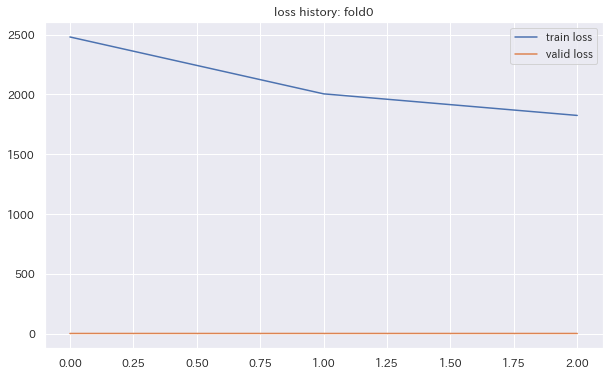

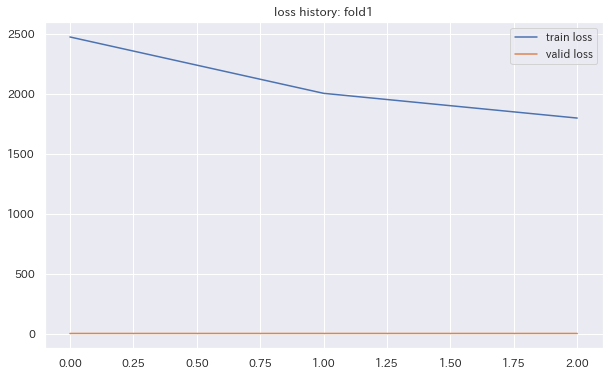

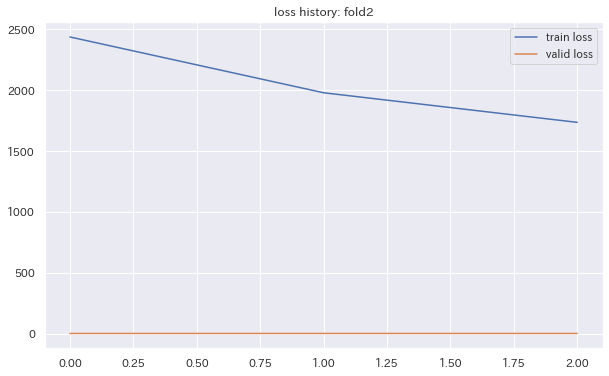

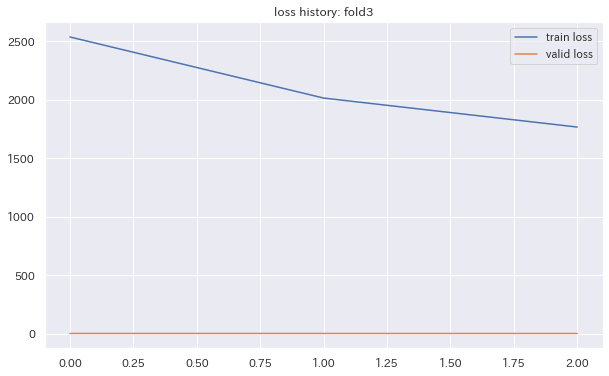

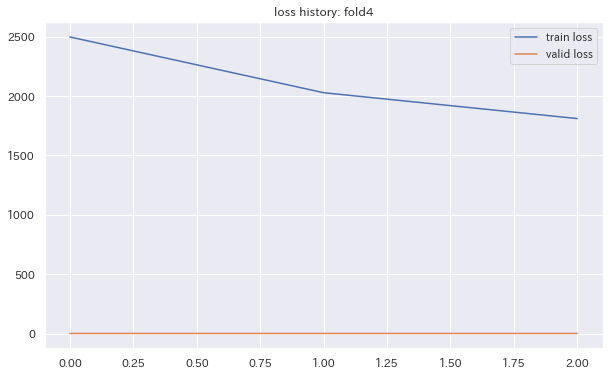

In [ ]:
start_time = time.time()

oof = pd.DataFrame()
for i_fold in range(Config.n_fold):
    print('='*50, f'fold{i_fold} training', '='*50)
    tokenizer = LongformerTokenizerFast.from_pretrained(Config.model_name, add_prefix_space = True)
    model = FeedbackModel()
    model = model.to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=Config.lr)
    
    df_train = alltrain_texts[alltrain_texts['fold'] != i_fold].reset_index(drop = True)
    ds_train = FeedbackPrizeDataset(df_train, tokenizer, Config.max_length, True)
    df_val = alltrain_texts[alltrain_texts['fold'] == i_fold].reset_index(drop = True)
    val_idlist = df_val['id'].unique().tolist()
    df_val_eval = df_alltrain.query('id==@val_idlist').reset_index(drop=True)
    ds_val = FeedbackPrizeDataset(df_val, tokenizer, Config.max_length, True)
    dl_train = DataLoader(ds_train, batch_size=Config.train_batch_size, shuffle=True, num_workers=2, pin_memory=True)
    dl_val = DataLoader(ds_val, batch_size=Config.valid_batch_size, shuffle=False, num_workers=2, pin_memory=True)

    best_val_loss = np.inf
    criterion = nn.CrossEntropyLoss()

    train_loss_history = []
    valid_loss_history = []

    for epoch in range(1, Config.n_epoch + 1):
        train_loss = train_fn(model, dl_train, optimizer, epoch, criterion) # train
        train_loss_history.append(train_loss) # train lossの保存

        valid_loss, _oof = valid_fn(model, df_val, df_val_eval, dl_val, epoch, criterion) # validation
        valid_loss_history.append(valid_loss) # valid lossの保存
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            _oof_fold_best = _oof
            _oof_fold_best['fold'] = i_fold
            model_filename = f'{Config.model_dir}/{Config.model_savename}_{i_fold}.bin'
            torch.save(model.state_dict(), model_filename)
            print(f'{model_filename} saved')
    
    # lossの描画
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    sns.lineplot(data=train_loss_history, label='train loss')
    sns.lineplot(data=valid_loss_history, label='valid loss')
    ax.set_title(f'loss history: fold{i_fold}')
    plt.legend();

    oof = pd.concat([oof, _oof_fold_best])
    del df_train, ds_train, df_val, val_idlist, df_val_eval, ds_val, dl_train, dl_val, tokenizer, model, optimizer
    gc.collect()

print(f'{time.time() - start_time:.1f}s')

In [ ]:
oof.head()

,id,class,new_predictionstring,fold
0,F48EF80D2ED3,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,0
1,F48EF80D2ED3,Position,30 31 32 33 34 35,0
2,F48EF80D2ED3,Claim,38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53,0
3,F48EF80D2ED3,Claim,54 55 56 57 58 59,0
4,F48EF80D2ED3,Evidence,83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 9...,0


In [ ]:
oof.to_csv(f'{Config.output_dir}/oof_{Config.name}.csv', index=False)

In [ ]:
pd.read_csv(f'{Config.output_dir}/oof_{Config.name}.csv').head()

,id,class,new_predictionstring,fold
0,F48EF80D2ED3,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,0
1,F48EF80D2ED3,Position,30 31 32 33 34 35,0
2,F48EF80D2ED3,Claim,38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53,0
3,F48EF80D2ED3,Claim,54 55 56 57 58 59,0
4,F48EF80D2ED3,Evidence,83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 9...,0


## cv score

In [ ]:
if Config.is_debug:
    idlist = alltrain_texts['id'].unique().tolist()
    df_train = df_alltrain.query('id==@idlist')
else:
    df_train = df_alltrain.copy()
print(f'overall cv score: {oof_score(df_train, oof)}')

Lead      : 0.775774
Position  : 0.638496
Claim     : 0.521205
Counterclaim: 0.440829
Rebuttal  : 0.317386
Evidence  : 0.636392
Concluding Statement: 0.769757
overall cv score: 0.5856913087564962
